In [1]:
from datetime import datetime
import math
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
import pickle

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_squared_error 
import numpy as np

In [2]:
df = pd.read_csv('Data/Month_Indicators.csv')
rate = pd.read_excel('Data/Taxa Desemprego INE.xls')

In [3]:
#  Corrigir as diferenças e datas dos datasets
rate.Data = df.date
rate.rename(columns={'Data':'date'},inplace=True)
df = pd.merge(df, rate, on='date')
dates= np.arange(np.datetime64("2004-01-01"), np.datetime64("2022-04-01"),  
                np.timedelta64(1, 'M'),  dtype='datetime64[M]') 
df['date']=dates
df.set_index('date', inplace=True)

In [4]:
# mostrar e salvar target inicial
df.tail()
real_pct = df['Pct']

In [5]:
class Preprocess:
    def __init__(self, data):
        self.data= data
        self.correct_names()
        self.data_size = self.data.columns
        self.target_name = self.data.columns[-1]
        self.correct_names()
        self.transformation_measures={}
        

    def correct_names(self):
        self.data.columns = [name.replace(' ', '_') for name in self.data.columns]
    
    def reupdate_cols(self):
        ''' every time main dataframe columns are change'''
        self.data_size = self.data.columns
        self.target_name = self.data.columns[-1]
        self.correct_names()
     
        
    def visualize(self, label):
        nrows = len(self.data_size)/2
        nrows = math.ceil(nrows)
        fig, ax = plt.subplots(nrows=nrows, ncols=2, dpi=120, figsize=(5*nrows,20))
        index = 0
        for row in range(nrows):
            for col in range(2):        
                ax[row, col].plot(self.data.iloc[:,index],  color='red', linewidth=1)
                ax[row, col].set_title(str(self.data.columns[index]), fontsize=16)
                ax[row, col].axhline(0, linestyle='--', color='k', alpha=0.3)
                ax[row, col].set_ylabel(label, fontsize=16)
                index +=1
                
    
    def normalize(self):
        for col in self.data_size:
            avg, std = self.data[col].mean(), self.data[col].std()
            self.data[col] = (self.data[col]- avg)/std
            if col == self.target_name:
                self.transformation_measures['normalize']=[avg, std]
                    
                
    def stationary(self):
        '''
        If its stationary then its mean, variance and auto-covariance are independent of time.
        Which implies that has no trend or seasonality 
        '''
        for col in self.data_size:
            dftest = adfuller(self.data[col], autolag = 'AIC')
            output = f'Indicator: {col}\nADF:{dftest[0]}\nP-Value: {dftest[1]}\nNº Lags: {dftest[2]}'
            print(output)
            for key, val in dftest[4].items():
                print("\t",key, ": ", val)
            print('\n \n')
        #p-value > 0.05: Fail to reject -> non-stationary.
        #p-value <= 0.05: Reject  -> stationary.
    
    
    def remove_trend(self):
        for col in self.data_size:
            if col == self.target_name:
                self.transformation_measures['trend']=self.data[col]
            self.data[col]= self.data[col].diff().dropna()
        self.data.dropna(axis=0, how='all', inplace=True)
        

    def remove_seasonality(self):
        for col in self.data_size:
            month = self.data[col].groupby(self.data[col].index.month).mean()
            month = self.data[col].index.map(lambda d: month.loc[d.month])
            if col == self.target_name:
                self.transformation_measures['seasonality']=month.values
            self.data[col] = self.data[col] - month
        self.data.dropna(axis=0, how='all', inplace=True)
    
    def autocorrelation_plots(self):
        plot_pacf(self.data.iloc[:,-1])
        plt.show()
        
        plot_acf(self.data.iloc[:,-1])
        plt.show()
        
        

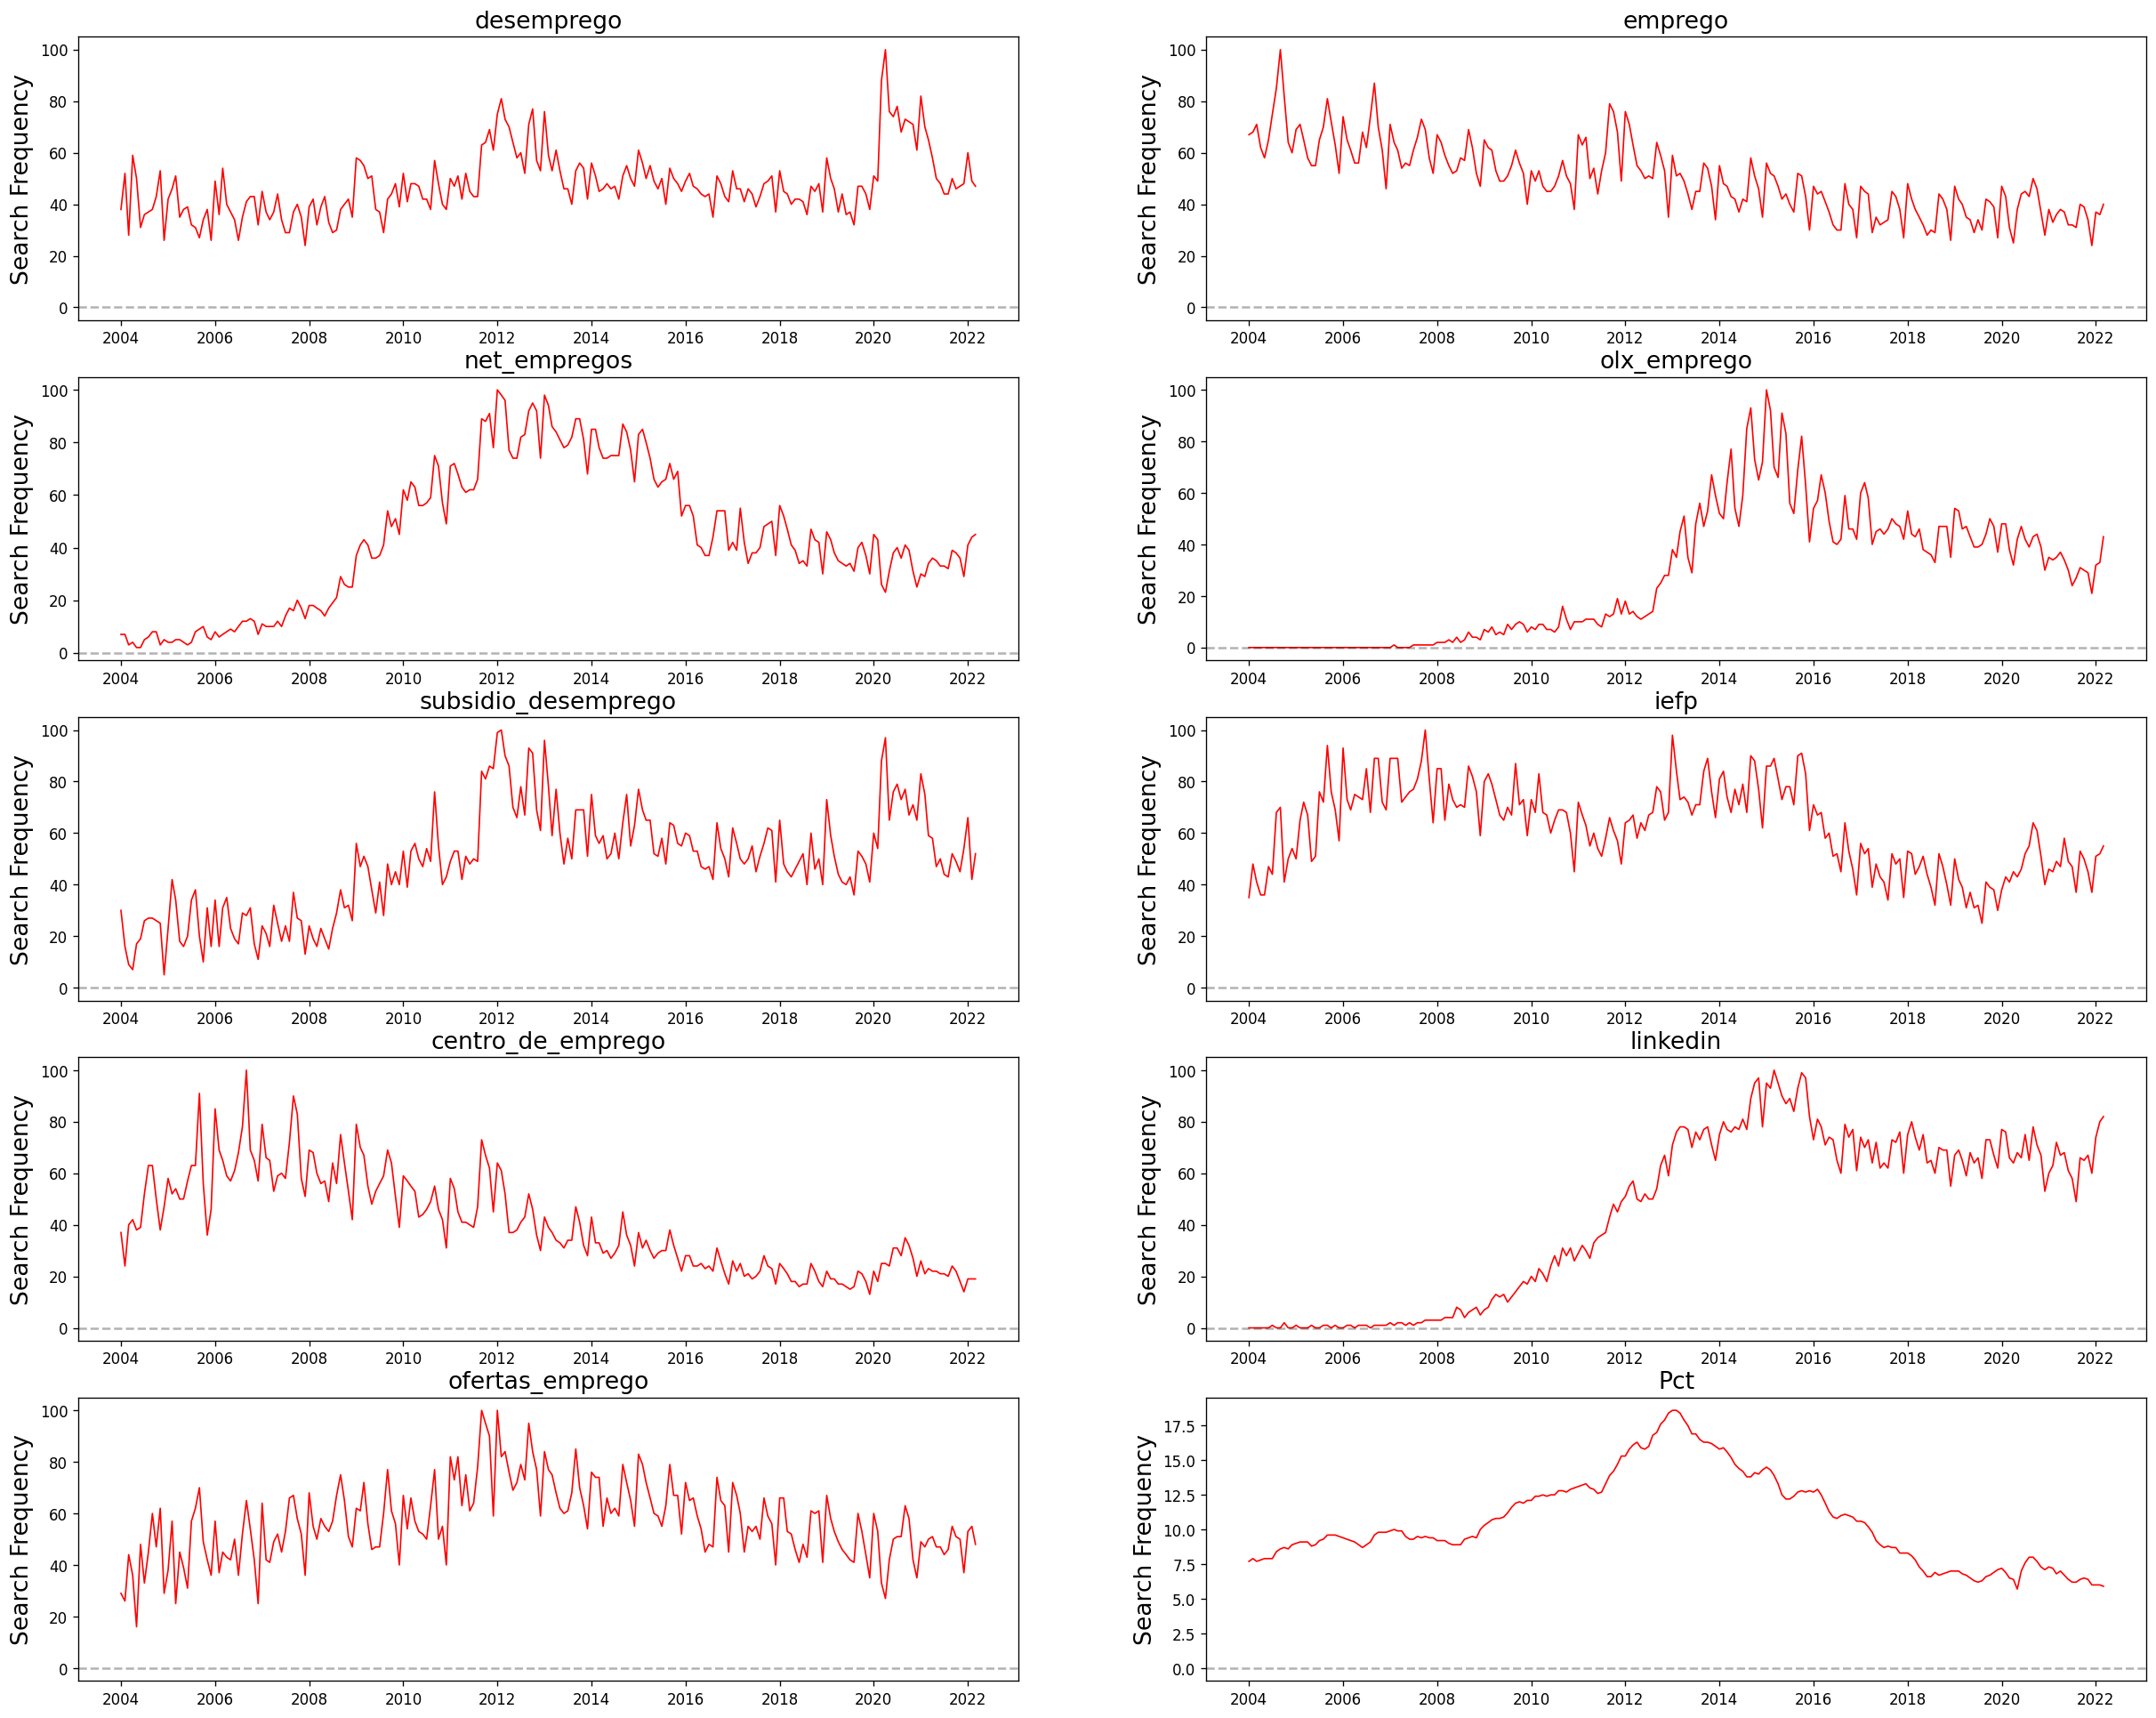

In [6]:
df_clean = Preprocess(df)
df_clean.visualize('Search Frequency')

In [7]:
df_clean.data.head(10)
#df_clean.data.drop('olx_emprego', inplace=True, axis=1)
#df_clean.reupdate_cols()

,desemprego,emprego,net_empregos,olx_emprego,subsidio_desemprego,iefp,centro_de_emprego,linkedin,ofertas_emprego,Pct
date,,,,,,,,,,
2004-01-01,38,67,7,0,30,35,37,0,29,7.7
2004-02-01,52,68,7,0,16,48,24,0,26,7.9
2004-03-01,28,71,3,0,9,41,40,0,44,7.7
2004-04-01,59,62,4,0,7,36,42,0,36,7.8
2004-05-01,50,58,2,0,17,36,38,0,16,7.9
2004-06-01,31,65,2,0,19,47,39,0,48,7.9
2004-07-01,36,75,5,0,26,44,52,1,33,7.9
2004-08-01,37,85,6,0,27,68,63,0,45,8.4
2004-09-01,38,100,8,0,27,70,63,0,60,8.6


In [8]:
#Teste Estacionaridade 
df_clean.stationary()

Indicator: desemprego
ADF:-2.5578486919508068
P-Value: 0.10202572376497376
Nº Lags: 15
	 1% :  -3.462980134086401
	 5% :  -2.875885461947131
	 10% :  -2.5744164898444515

 

Indicator: emprego
ADF:-1.676054482212274
P-Value: 0.44349022964552637
Nº Lags: 12
	 1% :  -3.4624988216864776
	 5% :  -2.8756749365852587
	 10% :  -2.5743041549627677

 

Indicator: net_empregos
ADF:-1.8107904976889018
P-Value: 0.3751178233627669
Nº Lags: 12
	 1% :  -3.4624988216864776
	 5% :  -2.8756749365852587
	 10% :  -2.5743041549627677

 

Indicator: olx_emprego
ADF:-1.7491474230721633
P-Value: 0.40598451619474557
Nº Lags: 14
	 1% :  -3.462818103072159
	 5% :  -2.8758145932936805
	 10% :  -2.574378674548251

 

Indicator: subsidio_desemprego
ADF:-2.06122033814417
P-Value: 0.2603911569830586
Nº Lags: 12
	 1% :  -3.4624988216864776
	 5% :  -2.8756749365852587
	 10% :  -2.5743041549627677

 

Indicator: iefp
ADF:-2.034049402890312
P-Value: 0.2718459958234136
Nº Lags: 14
	 1% :  -3.462818103072159
	 5% :  -2.875

In [9]:
#Remover Estacionaridade 
df_clean.normalize()
df_clean.remove_trend()
df_clean.remove_seasonality()

/home/ghk21nznz/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


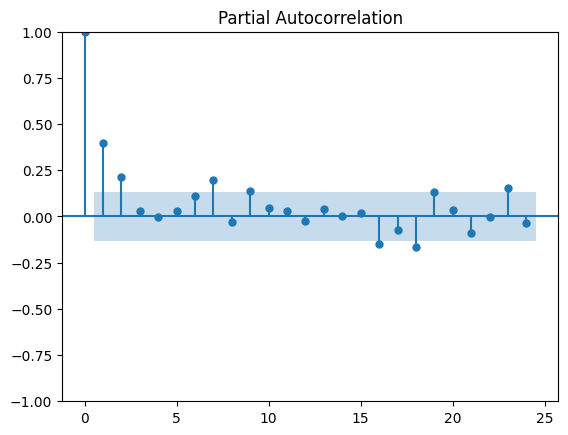

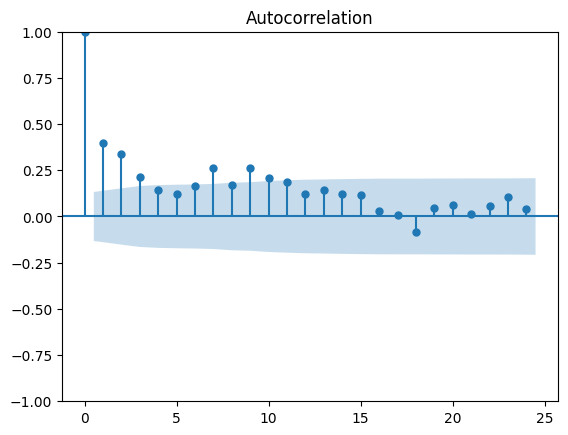

In [10]:
# Graficos de Autocorrelação
df_clean.autocorrelation_plots()
! warnings=False

Existe uma autocorrelação significativa, para justificar utilizar modelo autoregressão

# Modelos

In [11]:
class Models:
    def __init__(self, data, target_col_name):
        self.data= data
        self.lag = 1 #default 
        self.target_col_name = target_col_name
        
        #Divisão Treino-Teste
        self.test_obs = math.floor(len(self.data)*0.05) #ultimos 5% dos dados 
        self.train = self.data[:-self.test_obs]
        self.test = self.data[self.target_col_name].iloc[-self.test_obs:]
    
    def var(self, maxlag, loss):
        model = VAR(self.train).fit(maxlags=maxlag, ic=loss)
        print(model.summary())
        self.lag= model.k_ar
        pred = model.forecast(y=self.data.values[-self.lag:], steps=self.test_obs)
        return pd.DataFrame(pred, index=self.test.index, columns=self.data.columns)
    

    def autoreg(self):
        reg = AutoReg(self.train[self.target_col_name], lags=self.lag).fit()
        pred = reg.model.predict(reg.params, start=self.test.index.min(), end=self.test.index.max())
        return pd.DataFrame(pred, index=self.test.index, columns=[self.target_col_name])

    
    def invert_transformations(self, target, transformation_measures):
        size = target.size
        # add seasonality
        target += transformation_measures['seasonality'][-size:]
        # add first diff
        pre_diff = transformation_measures['trend'].shift(1)
        target += pre_diff[-size:]
        # denormalize
        target = target * transformation_measures['normalize'][1] + transformation_measures['normalize'][0]
        return target
    
    @staticmethod 
    def model_eff(real, predicted):
        print(f'r2_score: {r2_score(real, predicted)}, MSE: {mean_squared_error(real, predicted)}')

In [12]:
# Criar autoregressão e vetor autoregressivo;
# Usar os modelos para prever os ultimos 5% dos meses 

# Print corresponde ao summary do VAR
models_instance = Models(df_clean.data, 'Pct')
var_pred = models_instance.var(maxlag = 8, loss='aic') 
reg_pred = models_instance.autoreg()

/home/ghk21nznz/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ghk21nznz/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 14, Dec, 2022
Time:                     19:06:44
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -24.2263
Nobs:                     205.000    HQIC:                  -27.2189
Log likelihood:           399.442    FPE:                2.02508e-13
AIC:                     -29.2514    Det(Omega_mle):     4.95292e-14
--------------------------------------------------------------------
Results for equation desemprego
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                         -0.004218         0.034571           -0.122           0.903
L1.desemprego                 -0.387161         0.110256           -3.511           0.000
L1.emprego         

/home/ghk21nznz/.local/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [13]:
var_pred = var_pred['Pct']
var_pred.tail()

date
2021-11-01   -0.007463
2021-12-01    0.000392
2022-01-01    0.000580
2022-02-01    0.000409
2022-03-01   -0.002627
Name: Pct, dtype: float64

In [14]:
reg_pred = reg_pred['Pct']
reg_pred.tail()

date
2021-11-01    0.004149
2021-12-01    0.003201
2022-01-01    0.002549
2022-02-01    0.002097
2022-03-01    0.001784
Name: Pct, dtype: float64

In [15]:
var_pred= models_instance.invert_transformations(var_pred, df_clean.transformation_measures)
reg_pred= models_instance.invert_transformations(reg_pred, df_clean.transformation_measures)

In [16]:
real_pct_test = real_pct.iloc[-models_instance.test_obs:]
real_pct_test.tail()

date
2021-11-01    6.4
2021-12-01    6.0
2022-01-01    6.0
2022-02-01    6.0
2022-03-01    5.9
Name: Pct, dtype: float64

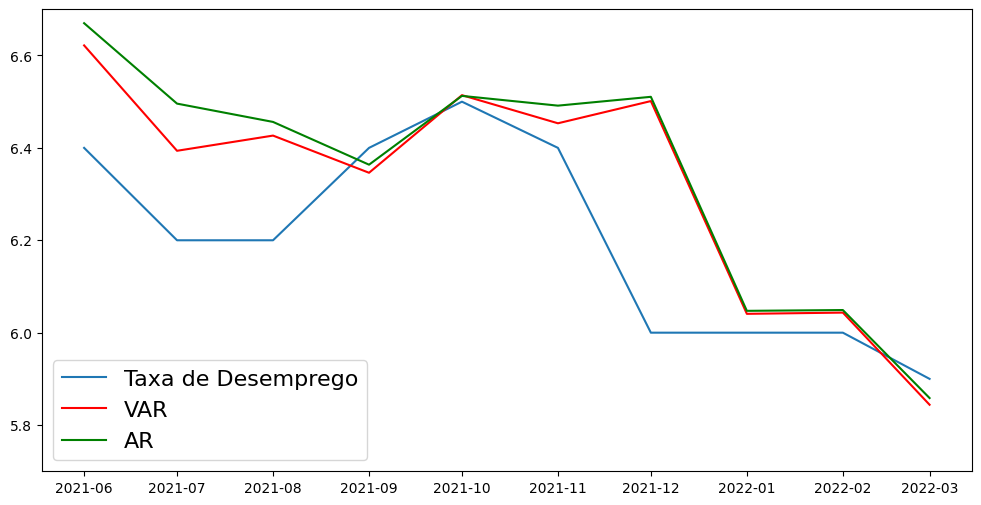

In [17]:
plt.figure(figsize=(12,6))
ppct, = plt.plot(real_pct_test)
ppred, = plt.plot(var_pred, color='red')
ppgreen, = plt.plot(reg_pred, color='green')
plt.ylim([5.7, 6.7])
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.legend(['Taxa de Desemprego', 'VAR', 'AR'], fontsize=16)

In [18]:
# Performance para VAR E AR respetivamente
models_instance.model_eff(real_pct_test, var_pred)
models_instance.model_eff(real_pct_test, reg_pred)

r2_score: 0.04291130386699504, MSE: 0.04019772523758623
r2_score: -0.19713153272548123, MSE: 0.05027952437447024


# DFA Model

In [19]:
# Ler Excel e inverter as transformações dos Fatores criados atraves do DFA no R 
dfa = pd.read_csv('Data/estimates_dfm.csv')
dfa.columns = ['Pct']
dfa.index = df_clean.data.index
dfa = dfa['Pct']
dfa_pred= models_instance.invert_transformations(dfa, df_clean.transformation_measures)

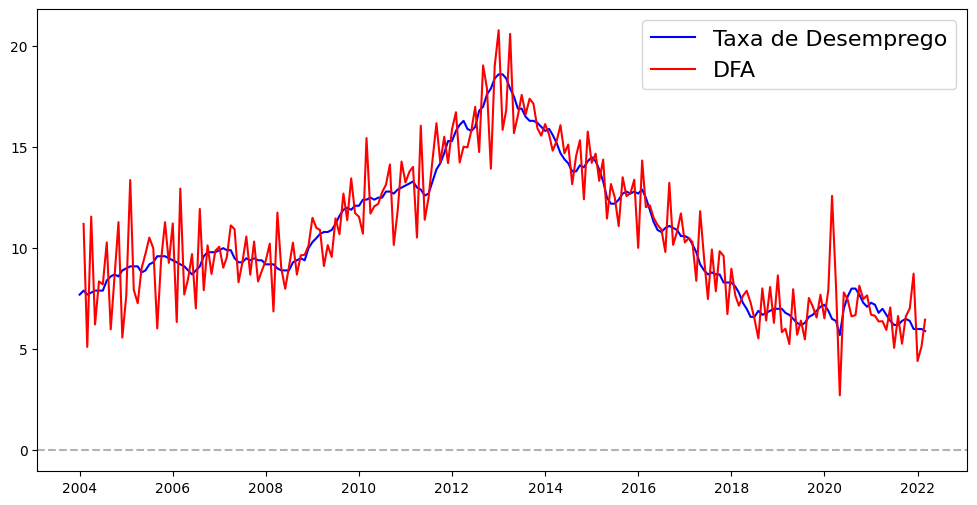

In [20]:
plt.figure(figsize=(12,6))
ppct, = plt.plot(real_pct, color='blue')
ppred, = plt.plot(dfa_pred, color='red')
#acrescentar ultimos 6 meses outra cor 
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.legend(['Taxa de Desemprego', 'DFA'], fontsize=16)